In [1]:
%matplotlib inline
import random

import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.cluster import MiniBatchKMeans
import datetime as dt

# Tested with Gurobi v9.0.0 and Python 3.7.0

seed = 10101
num_customers = 100
num_candidates = 7
max_facilities = 3
num_clusters = 100
num_gaussians = 10
threshold = 0.99
cust_latlong_dem_actual = pd.read_csv('dcs_lat_longs.csv')
feasible_lcs = pd.read_excel('Feasible_LC_Locations.xlsx')

In [2]:
dc_weights = pd.read_excel('Full_Demand_CustZIP_DC_Weights.xlsx')

In [3]:
dc_weights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Full_Cust_ZIP_DC_Cost  46 non-null     float64
 1   Full_Cust_ZIP_DC_Serv  46 non-null     float64
dtypes: float64(2)
memory usage: 868.0 bytes


In [4]:
cust_latlong_dem_actual['Weight (lbs)'] = dc_weights['Full_Cust_ZIP_DC_Cost']

In [5]:
facility_locs = feasible_lcs[['Lat','Long']].values

In [6]:
def haversine_distance(loc1, loc2, circuity_factor=1.3):
    """
    Calculate the Haversine distance between two points on the Earth's surface.

    Parameters:
        lat1 (float): Latitude of the first point (in degrees).
        lon1 (float): Longitude of the first point (in degrees).
        lat2 (float): Latitude of the second point (in degrees).
        lon2 (float): Longitude of the second point (in degrees).
        circuity_factor (float): Circuity factor to adjust the distance (default is 1.0).

    Returns:
        float: Haversine distance adjusted by the circuity factor.
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [loc1[0], loc1[1], loc2[0], loc2[1]])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6371 * c  # Radius of the Earth in kilometers

    # Adjust distance based on circuity factor
    adjusted_distance = distance * circuity_factor*0.621371

    return adjusted_distance

In [7]:
weights = cust_latlong_dem_actual['Weight (lbs)'].values
customer_locs = cust_latlong_dem_actual[['latitude','longitude']].values

In [8]:
pairings = {(facility, cluster): haversine_distance(facility_locs[facility], customer_locs[cluster])
            for facility in range(len(facility_locs))
            for cluster in range(len(customer_locs))}
            #if  dist(facility_locs[facility], centroids[cluster]) < threshold}
            
print("Number of viable pairings: {0}".format(len(pairings.keys())))

Number of viable pairings: 10994


In [9]:
m = gp.Model("Facility location")

# Decision variables: select facility locations
select = m.addVars(range(len(facility_locs)), vtype=GRB.BINARY, name='select')
# Decision variables: assign customer clusters to a facility location
assign = m.addVars(pairings.keys(), vtype=GRB.BINARY, name='assign')

# Deploy Objective Function
# 0. Total distance
obj = gp.quicksum(1
               *pairings[facility, cluster]
               *assign[facility, cluster]
               for facility, cluster in pairings.keys())
m.setObjective(obj, GRB.MINIMIZE)

# 1. Facility limit
m.addConstr(select.sum() <= max_facilities, name="Facility_limit")

# Testing Freeze certain decision variables to be 1
#for i in range(len(facility_locs)):
#    if i in [5]:  # indices_to_freeze is a list of indices to be frozen at 1
#        select[i].lb = 1  # Set lower bound to 1
#        select[i].ub = 1  # Set upper bound to 1

# 2. Open to assign
m.addConstrs((assign[facility, cluster] <= select[facility]
             for facility, cluster in pairings.keys()),
            name="Open2assign")

# 3. Closest store
m.addConstrs((assign.sum('*', cluster) == 1
             for cluster in range(len(customer_locs))),
            name="Closest_store")

# Find the optimal solution
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-04
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 23.2.0 23C71)

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 11041 rows, 11233 columns and 33221 nonzeros
Model fingerprint: 0xb3968703
Variable types: 0 continuous, 11233 integer (11233 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 7e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve time: 0.04s
Presolved: 11041 rows, 11233 columns, 33221 nonzeros
Variable types: 0 continuous, 11233 integer (11233 binary)
Found heuristic solution: objective 24593.610102

Root relaxation: objective 2.242488e+04, 3288 iterations, 0.07 seconds (0.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | I

In [10]:
#select

In [11]:
#assign

In [12]:
all_vars = m.getVars()
values = m.getAttr("X", all_vars)
names = m.getAttr("VarName", all_vars)

#for name, val in zip(names, values):
 #   if val == 1.0:
        #print(f"{name} = {val}")
model_variables = pd.DataFrame({'Variable': names, 'Value': values})

In [13]:
model_variables

,Variable,Value
0,select[0],-0.0
1,select[1],-0.0
2,select[2],-0.0
3,select[3],-0.0
4,select[4],-0.0
...,...,...
11228,"assign[238,41]",-0.0
11229,"assign[238,42]",-0.0
11230,"assign[238,43]",-0.0
11231,"assign[238,44]",-0.0


In [14]:
# new data frame with split value columns 
splitData = model_variables["Variable"].str.split(",", n=1, expand=True)

# making new column Pos from first part of the split data, 
# also remove front and back brackets if any
model_variables["Facility"] = splitData[0].str.strip()
model_variables['Facility'] = model_variables['Facility'].str.extract(r'(\d+)')

# making new column state from second part of the split data, 
# also remove front and back brackets if any
model_variables["CustomerIndex"] = splitData[1].str.strip("()")
model_variables['CustomerIndex'] = model_variables['CustomerIndex'].str.extract(r'(\d+)')

In [15]:
routes_assigned = model_variables[len(facility_locs):]
routes_assigned.reset_index(drop = True, inplace = True)

routes_assigned['Facility'] = routes_assigned['Facility'].astype(int)
routes_assigned['CustomerIndex'] = routes_assigned['CustomerIndex'].astype(int)
#routes_assigned['CustomerId'] = routes_assigned['CustomerIndex'] + 1

distances = pd.DataFrame.from_dict(pairings, orient = 'index')
distances = distances.reset_index()

routes_assigned = pd.concat([routes_assigned, distances], axis = 1)

/var/folders/2r/tkd0g52s6k35vzy9v1_cn3zh0000gn/T/ipykernel_16667/388758391.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_assigned['Facility'] = routes_assigned['Facility'].astype(int)
/var/folders/2r/tkd0g52s6k35vzy9v1_cn3zh0000gn/T/ipykernel_16667/388758391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  routes_assigned['CustomerIndex'] = routes_assigned['CustomerIndex'].astype(int)


In [16]:
routes_assigned.rename(columns={'index': 'Pairing', 0: 'Distance_Miles','Value':'Assignment'}, inplace=True)

routes_assigned = routes_assigned.merge(feasible_lcs,how='left',left_on='Facility',right_index=True)

routes_assigned = routes_assigned.merge(cust_latlong_dem_actual,how='left',left_on='CustomerIndex',right_index = True)

routes_assigned.rename(columns={'City': 'LC_City', 'State': 'LC_State','Lat':'LC_Lat',
                                'Long':'LC_Long','latitude':'Cust_Lat','longitude':'Cust_Long',
                               'Weight (lbs)':'DEMAND'}, inplace=True)

routes_assigned = routes_assigned.drop(['Unnamed: 0'], axis = 1)
#routes_assigned = routes_assigned.drop(['CustomerId','LATITUDE_LONGITUDE'], axis = 1)

In [17]:
routes_assigned.head()

,Variable,Assignment,Facility,CustomerIndex,Pairing,Distance_Miles,City_x,State_x,LC_Lat,LC_Long,...,state_name,state_code,county_name,county_code,community_name,community_code,Cust_Lat,Cust_Long,accuracy,DEMAND
0,"assign[0,0]",0.0,0,0,"(0, 0)",856.178677,Grand Prairie,TX,32.6871,-97.0208,...,Colorado,CO,Denver,31.0,NaN,NaN,39.7392,-104.9847,4.0,2284516.1
1,"assign[0,1]",0.0,0,1,"(0, 1)",282.086138,Grand Prairie,TX,32.6871,-97.0208,...,Texas,TX,Harris,201.0,NaN,NaN,29.8052,-95.5607,4.0,1732925.2
2,"assign[0,2]",0.0,0,2,"(0, 2)",608.250332,Grand Prairie,TX,32.6871,-97.0208,...,Missouri,MO,Platte,165.0,NaN,NaN,39.1776,-94.6321,4.0,3285581.4
3,"assign[0,3]",0.0,0,3,"(0, 3)",573.083170,Grand Prairie,TX,32.6871,-97.0208,...,Louisiana,LA,Jefferson Parish,51.0,NaN,NaN,29.9912,-90.2479,4.0,2748471.8
4,"assign[0,4]",-0.0,0,4,"(0, 4)",1131.779879,Grand Prairie,TX,32.6871,-97.0208,...,Arizona,AZ,Maricopa,13.0,NaN,NaN,33.4413,-112.0421,4.0,1715261.6


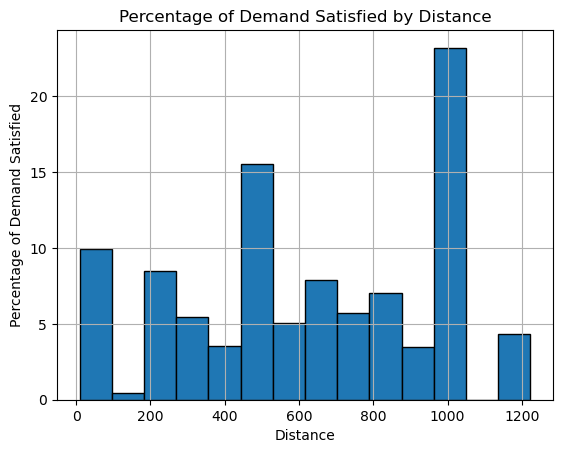

In [18]:
import matplotlib.pyplot as plt

# Sample data
filtered_df = routes_assigned[routes_assigned['Assignment'] == 1.0]
distances = filtered_df['Distance_Miles']  # Distance values
total_demand = sum(filtered_df['DEMAND'])  # Total demand
demands_satisfied = filtered_df['DEMAND']  # Demands satisfied at each distance

# Calculate percentage of demand satisfied at each distance
percentage_satisfied = [(demand / total_demand) * 100 for demand in demands_satisfied]

# Plot as a histogram with 14 bins
plt.hist(distances, bins=14, weights=percentage_satisfied, edgecolor='black')
plt.title('Percentage of Demand Satisfied by Distance')
plt.xlabel('Distance')
plt.ylabel('Percentage of Demand Satisfied')
plt.grid(True)
plt.show()


In [19]:
filtered_df.to_excel('FULL_3LC_Cust_ZIP_DC_Serv.xlsx')

In [20]:
filtered_df['City_x'].unique()

array(['Salt Lake City', 'Knoxville', 'Anaheim'], dtype=object)

In [21]:
filtered_df[filtered_df['City_x'] == 'Knoxville']

,Variable,Assignment,Facility,CustomerIndex,Pairing,Distance_Miles,City_x,State_x,LC_Lat,LC_Long,...,state_name,state_code,county_name,county_code,community_name,community_code,Cust_Lat,Cust_Long,accuracy,DEMAND
3543,"assign[77,1]",1.0,77,1,"(77, 1)",1034.936609,Knoxville,TN,35.9692,-83.9496,...,Texas,TX,Harris,201.0,NaN,NaN,29.8052,-95.5607,4.0,1732925.2
3544,"assign[77,2]",1.0,77,2,"(77, 2)",812.616103,Knoxville,TN,35.9692,-83.9496,...,Missouri,MO,Platte,165.0,NaN,NaN,39.1776,-94.6321,4.0,3285581.4
3545,"assign[77,3]",1.0,77,3,"(77, 3)",716.236480,Knoxville,TN,35.9692,-83.9496,...,Louisiana,LA,Jefferson Parish,51.0,NaN,NaN,29.9912,-90.2479,4.0,2748471.8
3547,"assign[77,5]",1.0,77,5,"(77, 5)",988.158852,Knoxville,TN,35.9692,-83.9496,...,Oklahoma,OK,Cleveland,27.0,NaN,NaN,35.3340,-97.4768,4.0,9107736.0
3549,"assign[77,7]",1.0,77,7,"(77, 7)",1223.060964,Knoxville,TN,35.9692,-83.9496,...,Texas,TX,Guadalupe,187.0,NaN,NaN,29.5790,-98.2778,4.0,3240988.3
3551,"assign[77,9]",1.0,77,9,"(77, 9)",625.638448,Knoxville,TN,35.9692,-83.9496,...,Illinois,IL,Kane,89.0,NaN,NaN,42.0293,-88.3747,4.0,4816618.7
3552,"assign[77,10]",1.0,77,10,"(77, 10)",674.719832,Knoxville,TN,35.9692,-83.9496,...,Florida,FL,Seminole,117.0,NaN,NaN,28.8013,-81.2850,4.0,1069651.0
3553,"assign[77,11]",1.0,77,11,"(77, 11)",920.757825,Knoxville,TN,35.9692,-83.9496,...,Florida,FL,Broward,11.0,NaN,NaN,26.2120,-80.2696,4.0,1423641.8
3554,"assign[77,12]",1.0,77,12,"(77, 12)",499.669376,Knoxville,TN,35.9692,-83.9496,...,Ohio,OH,Summit,153.0,NaN,NaN,41.1748,-81.4380,4.0,2071863.3
3555,"assign[77,13]",1.0,77,13,"(77, 13)",311.357325,Knoxville,TN,35.9692,-83.9496,...,Ohio,OH,Butler,17.0,NaN,NaN,39.4059,-84.5221,4.0,2255663.8
